In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import collections
import sys
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn/pppc')
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn')
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cupy
from skimage.transform import resize

import tike
import tike.ptycho
import tike.view

/data/programs/tike/src/tike/communicators/mpi.py:414: UserWarning: tike was unable to import mpi4py, so MPI features are unavailable.
  warnings.warn(


In [3]:
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.viridis()

<Figure size 640x480 with 0 Axes>

In [4]:
def clean_data(arr):
    mask = arr < 0
    vals = arr[mask]
    vals = 32768 + (vals - -32768)
    arr[mask] = vals
    return arr

In [5]:
scan_idx = 251
save_figs = True
pos_corr = 1
type = 'calculated'
scaling_dict = collections.defaultdict(lambda: 1.0, {236: 0.5, 239: 0.5, 240: 0.25, 241: 0.25, 242: 0.25, 250: 0.5, 251: 0.5, 252: 0.25, 253: 0.25})

In [6]:
f = np.load('data/test{}.npz'.format(scan_idx))
data_raw = f['reciprocal']
if type == 'calculated':
    probe_pos_list_raw = np.genfromtxt('outputs/test{}/calc_pos_{}_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.csv'.format(scan_idx, scan_idx), delimiter=',').astype('float32')
    #probe_pos_list_raw *= 1.05
elif type == 'true':
    probe_pos_list_raw = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32')
elif type == 'baseline':
    s = scaling_dict = scaling_dict[scan_idx]
    print('Baseline position scaled by {}.'.format(s))
    probe_pos_list_raw = np.genfromtxt('data/pos221.csv', delimiter=',').astype('float32') * s  # Baseline
else:
    raise ValueError
probe_raw = np.load('tike_test/scan221_raw.npz')['probe']
probe_raw = probe_raw[0] + 1j * probe_raw[1]
probe_raw = probe_raw.astype('complex64')[None, :, :]
#probe = np.load('data/probe.npy')

print('data size: ', data_raw.shape)
print('probe size: ', probe_raw.shape)

data size:  (961, 512, 512)
probe size:  (1, 256, 256)


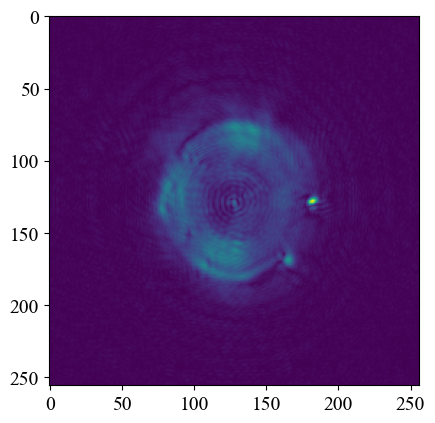

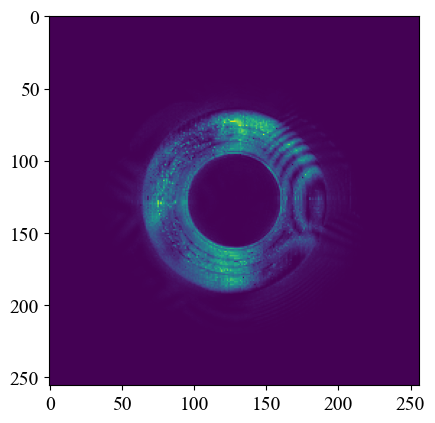

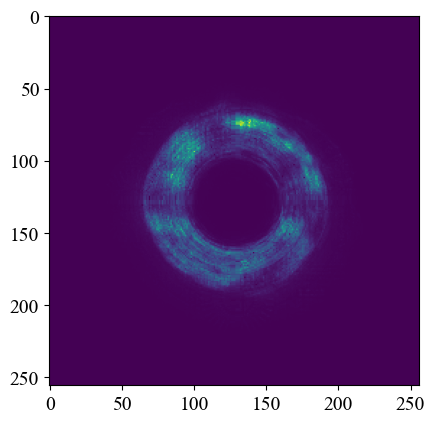

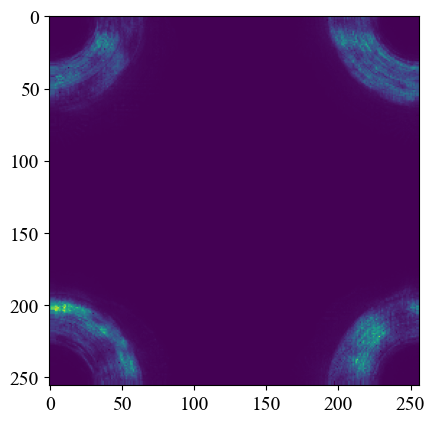

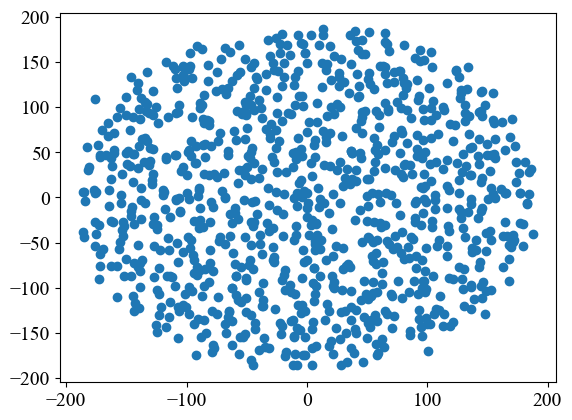

In [7]:
# Data transform:
# Use probe and pixel size in scan221_raw.npz. 
# If DP size is (256, 256), use as it is. (235, 247)
# If DP size is (512, 512), crop it to (256, 256) and flip left-right. 

psize_nm = 7.92

probe_pos_list = probe_pos_list_raw
# probe_pos_list *= -1
# probe_pos_list = probe_pos_list - np.min(probe_pos_list, axis=0)
probe_pos_list = probe_pos_list_raw / (psize_nm * 1e-9)
probe_pos_list = probe_pos_list

data = data_raw
data = clean_data(data)
data = data.astype('float32')
#data = transform_data_for_ptychonn(data, target_shape=(128, 128), discard_len=(64, 64))
#data = transform_data_for_ptychonn(data, target_shape=(128, 128), discard_len=(192, 192))
if data.shape[-1] == 512:
    data = data[:, 128:-128, -128:128:-1]
data = np.fft.fftshift(data, axes=(-1, -2))

probe = probe_raw
#probe_real = transform_data_for_ptychonn(probe.real, target_shape=(256, 256), discard_len=None)
#probe_imag = transform_data_for_ptychonn(probe.imag, target_shape=(256, 256), discard_len=None)
#probe = probe_real + 1j * probe_imag
probe = probe[np.newaxis, np.newaxis, :, :, :]
probe = tike.ptycho.probe.add_modes_random_phase(probe, 1)

plt.imshow(np.abs(probe[0, 0, 0]))
plt.show()
plt.imshow(np.fft.ifftshift(np.abs(np.fft.fft2(probe[0, 0, 0])) ** 2))
plt.show()
plt.imshow(np.fft.ifftshift(data[0]))
plt.show()
plt.imshow(data[0])
plt.show()
plt.scatter(probe_pos_list[:, 1], probe_pos_list[:, 0])

In [8]:
probe.shape, probe_pos_list.shape

((1, 1, 1, 256, 256), (961, 2))

In [9]:
psi, probe_pos_list = tike.ptycho.object.get_padded_object(probe_pos_list, probe, extra=60)
print(psi.shape)

(750, 753)


In [10]:
position_options = None
if pos_corr:
    position_options = tike.ptycho.PositionOptions(
        probe_pos_list,
        use_adaptive_moment=False,
        use_position_regularization=True,
        update_clipping=2,
        transform=tike.ptycho.position.AffineTransform()
    )
    
parameters = tike.ptycho.PtychoParameters(
    # Provide initial guesses for parameters that are updated
    probe=probe,
    scan=probe_pos_list,
    psi=psi,
    probe_options=tike.ptycho.ProbeOptions(), # uses default settings for probe recovery
    object_options=tike.ptycho.ObjectOptions(
        # The object will be updated.
        use_adaptive_moment=True,  # smoothness constraint will use our provided setting
        # other object options will be default values
    ),
    position_options=position_options,
    algorithm_options=tike.ptycho.RpieOptions(
        num_iter=128,
        num_batch=7,
    ),
)

In [11]:
logging.basicConfig(level=logging.INFO)

# returns an updated PtychoParameters object
result = tike.ptycho.reconstruct(
    data=data,
    parameters=parameters,
    num_gpu=1
)

INFO:tike.ptycho.ptycho:rpie on 961 - 256 by 256 frames for at most 128 epochs.
INFO:tike.cluster:Clustering method is stripes.
INFO:tike.cluster:Clustering method is wobbly center.
INFO:tike.ptycho.ptycho:Probe rescaled by 110.315813
INFO:tike.ptycho.ptycho:rpie epoch 0
INFO:tike.ptycho.ptycho:The object update mean-norm is 3.131e-02
INFO:tike.ptycho.ptycho:  gaussian cost is +8.012e+01
INFO:tike.ptycho.ptycho:rpie epoch 1
INFO:tike.ptycho.ptycho:The object update mean-norm is 4.539e-02
INFO:tike.ptycho.ptycho:  gaussian cost is +3.332e+01
INFO:tike.ptycho.ptycho:rpie epoch 2
INFO:tike.ptycho.ptycho:The object update mean-norm is 5.312e-02
INFO:tike.ptycho.ptycho:  gaussian cost is +2.560e+01
INFO:tike.ptycho.ptycho:rpie epoch 3
INFO:tike.ptycho.ptycho:The object update mean-norm is 5.753e-02
INFO:tike.ptycho.ptycho:  gaussian cost is +2.415e+01
INFO:tike.ptycho.ptycho:rpie epoch 4
INFO:tike.ptycho.ptycho:The object update mean-norm is 6.060e-02
INFO:tike.ptycho.ptycho:  gaussian cost

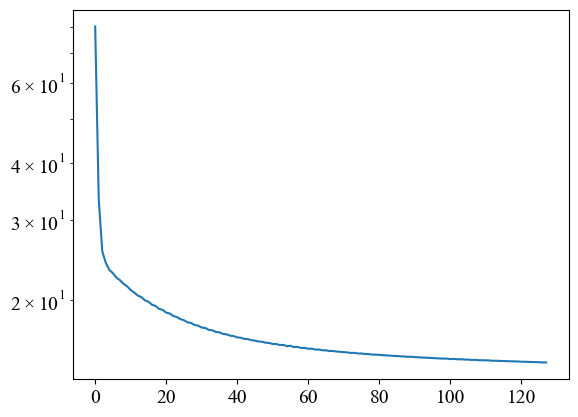

In [12]:
fig = plt.figure()
avg_cost = np.mean(np.stack(result.algorithm_options.costs, axis=0), axis=1)
plt.semilogy(avg_cost)
pos_corr_str = 'posCorr_1_clip_2' if pos_corr else 'posCorr_0'
if save_figs:
    if type == 'calculated':
        fig.savefig(os.path.join('outputs/test{}/loss_history_calc_pos_{}.pdf'.format(scan_idx, pos_corr_str)))
        np.savetxt(os.path.join('outputs/test{}/loss_history_calc_pos_{}.txt'.format(scan_idx, pos_corr_str)), avg_cost)
    elif type == 'true':
        fig.savefig(os.path.join('outputs/test{}/loss_history_true_pos.pdf'.format(scan_idx)))
        np.savetxt(os.path.join('outputs/test{}/loss_history_true_pos.txt'.format(scan_idx)), avg_cost)
    elif type == 'baseline':
        fig.savefig(os.path.join('outputs/test{}/loss_history_baseline_pos_{}.pdf'.format(scan_idx, pos_corr_str)))
        np.savetxt(os.path.join('outputs/test{}/loss_history_baseline_pos_{}.txt'.format(scan_idx, pos_corr_str)), avg_cost)
    else:
        raise ValueError
else:
    plt.show()


(0.13503735-0.09394686j) (1.0634542+0.5154275j)


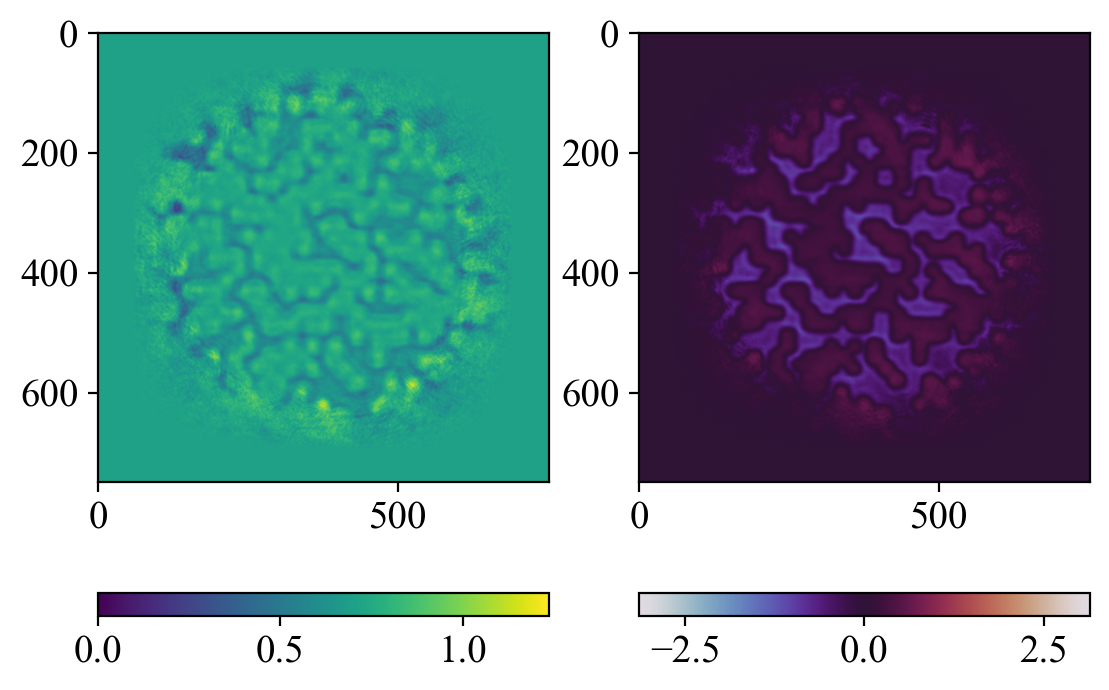

In [13]:
plt.figure(dpi=200)
tike.view.plot_phase(result.psi, amin=0)
plt.show()

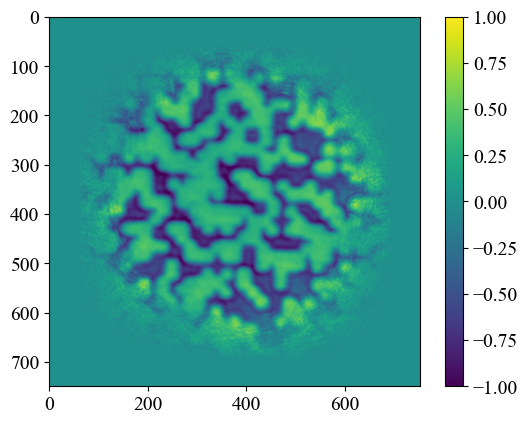

In [14]:
fig = plt.figure()
im = plt.imshow(np.angle(result.psi), vmin=-1, vmax=1)
plt.colorbar(im)
pos_corr_str = 'posCorr_1_clip_2' if pos_corr else 'posCorr_0'
if save_figs:
    if type == 'calculated':
        fig.savefig('outputs/test{}/rpie_{}_pos_collective_niters_2_beta_0p5_nn_12_sw_1e-2_1e-3.pdf'.format(scan_idx, pos_corr_str))
    elif type == 'true':
        fig.savefig('outputs/test{}/rpie_posCorr_0_pos_true.pdf'.format(scan_idx))
    elif type == 'baseline':
        fig.savefig('outputs/test{}/rpie_{}_pos_baseline.pdf'.format(scan_idx, pos_corr_str))
    else:
        raise ValueError
else:
    plt.show()

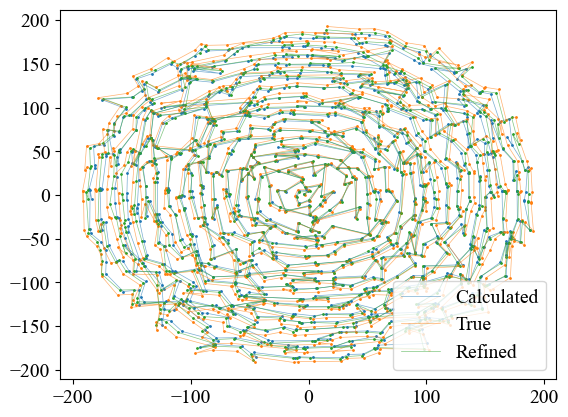

In [15]:
probe_pos_list_calc = probe_pos_list
probe_pos_list_true = np.genfromtxt('data/pos{}.csv'.format(scan_idx), delimiter=',').astype('float32') / (psize_nm * 1e-9)
probe_pos_list_refined = result.scan
probe_pos_list_calc -= np.mean(probe_pos_list_calc, axis=0)
probe_pos_list_true -= np.mean(probe_pos_list_true, axis=0)
probe_pos_list_refined -= np.mean(probe_pos_list_refined, axis=0)
# probe_pos_list_raw *= 1.05
plt.scatter(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], s=1)
plt.scatter(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], s=1)
plt.scatter(probe_pos_list_refined[:, 1], probe_pos_list_refined[:, 0], s=1)
plt.plot(probe_pos_list_calc[:, 1], probe_pos_list_calc[:, 0], linewidth=0.5, alpha=0.6, label='Calculated')
plt.plot(probe_pos_list_true[:, 1], probe_pos_list_true[:, 0], linewidth=0.5, alpha=0.6, label='True')
plt.plot(probe_pos_list_refined[:, 1], probe_pos_list_refined[:, 0], linewidth=0.5, alpha=0.6, label='Refined')
plt.legend()
if save_figs and type == 'calculated' and pos_corr:
    plt.savefig('outputs/test{}/comparison_path_plot_true_calc_refined_clip_2_collective_iter_2_nn_12_sw_1e-3_1e-2.pdf'.format(scan_idx))
else:
    plt.show()